# Tutorial 1: Quick Start Guide

This is the basics of using ysoisochrone

## Installation

The easiest way to install this package is using terminal, and change directory to the root direcotry of this package (where the `setup.py` exists).

```bash 
pip install .
```

which should install the necessary dependencies.

First make sure you have successfully installed the package. You can find out this by trying to import

In [1]:
import os, sys
import numpy as np
import pandas as pd

# if you do not want to install ysoisochrone to your system PATH
# you can also use the following script to temporarily add the package to your PATH
# """
github_dir = '/Users/dingshandeng/github/ysoisochrone/'
sys.path.append(os.path.join(github_dir))
# """

import ysoisochrone

### Download the stellar evolutionary models

When using the package for the first time, it will try to download the isochrones from online sources, so make sure you also have internet access. You might need to download some large files ($\sim 1\,$GB) for using the isochrones from certain models (such as PARSEC), so you also need to make sure you have a few GB left in the disk where you need to store the data.

By default, the code will create a folder called `isochrones_data` in the same directory that you are running the `Python` script. You can also change this by editing the `save_dir` argument in the `download_xxx` functions.

First, let's try to download the track from [Baraffe et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26A...577A..42B/abstract) and [Feiden (2016)](https://ui.adsabs.harvard.edu/abs/2016A%26A...593A..99F/abstract).

In [2]:
# download Baraffe tracks
ysoisochrone.utils.download_baraffe_tracks()

Downloading: 100%|█████████████████████████████████████████████| 1.35M/1.35M [00:00<00:00, 1.47MB/s]


Downloaded isochrones_data/Baraffe2015/BHAC15_tracks+structure
If you end up using the Baraffe et al. (2015) tracks, please cite from: https://ui.adsabs.harvard.edu/abs/2015A%26A...577A..42B/abstract


1


**NOTE**. 
If you want to store the data to a different directory, you can use

``` Python
save_dir_yourpath = 'Your_prefered_path'
ysoisochrone.utils.download_baraffe_tracks(save_dir=save_dir_yourpath)
```

You also only need to download them when you use the code for the first time.

In [3]:
# download Feiden tracks
ysoisochrone.utils.download_feiden_trk_tracks()

Downloading: 100%|█████████████████████████████████████████████| 39.7M/39.7M [00:01<00:00, 37.3MB/s]



Downloaded isochrones_data/Feiden2016_trk/all_GS98_p000_p0_y28_mlt1.884.tgz
Extracted isochrones_data/Feiden2016_trk/all_GS98_p000_p0_y28_mlt1.884.tgz into isochrones_data/Feiden2016_trk
All files downloaded and extracted in isochrones_data/Feiden2016_trk
If you use the Feiden tracks, please cite from: https://ui.adsabs.harvard.edu/abs/2016IAUS..314...79F/abstract


1

## Your first target

### Prepare the data

Then, you need to prepare your own data. The data needs to be in the format of `pandas.DataFrame` and with following columns `['Source', 'Teff[K]', 'e_Teff[K]', 'Luminosity[Lsun]', 'e_Luminosity[Lsun]']`. 

- `'Source'` is the list of source names. It can be just the ID numbers you prefer.
- `'Teff[K]'` is the effective temperature in the unit of Kelvin.
- and `'e_Teff[K]'` is the associated uncertainties. 
- `'Luminosity[Lsun]'` is the bolometric luminosities of these targets un the unit of solar luminosity. 
- and `'e_Luminosity[Lsun]'` is their uncertainties.

Here the uncertainties are $1\,\sigma$ value assuming they follow the Gaussian distribution.

In [3]:
# Set up a DataFrame in Python script
# For this target Sz71, values are from Alcala+2017, 
# and corrected later with the Gaia DR3 distance in Manara+2023
df_prop = pd.DataFrame({
    'Source': ['Sz71'],
    'Teff[K]': np.array([3632.0]),
    'e_Teff[K]': np.array([167.0]),
    'Luminosity[Lsun]': np.array([0.327]),
    'e_Luminosity[Lsun]': np.array([0.1420])
})

### Plot it on the HRD

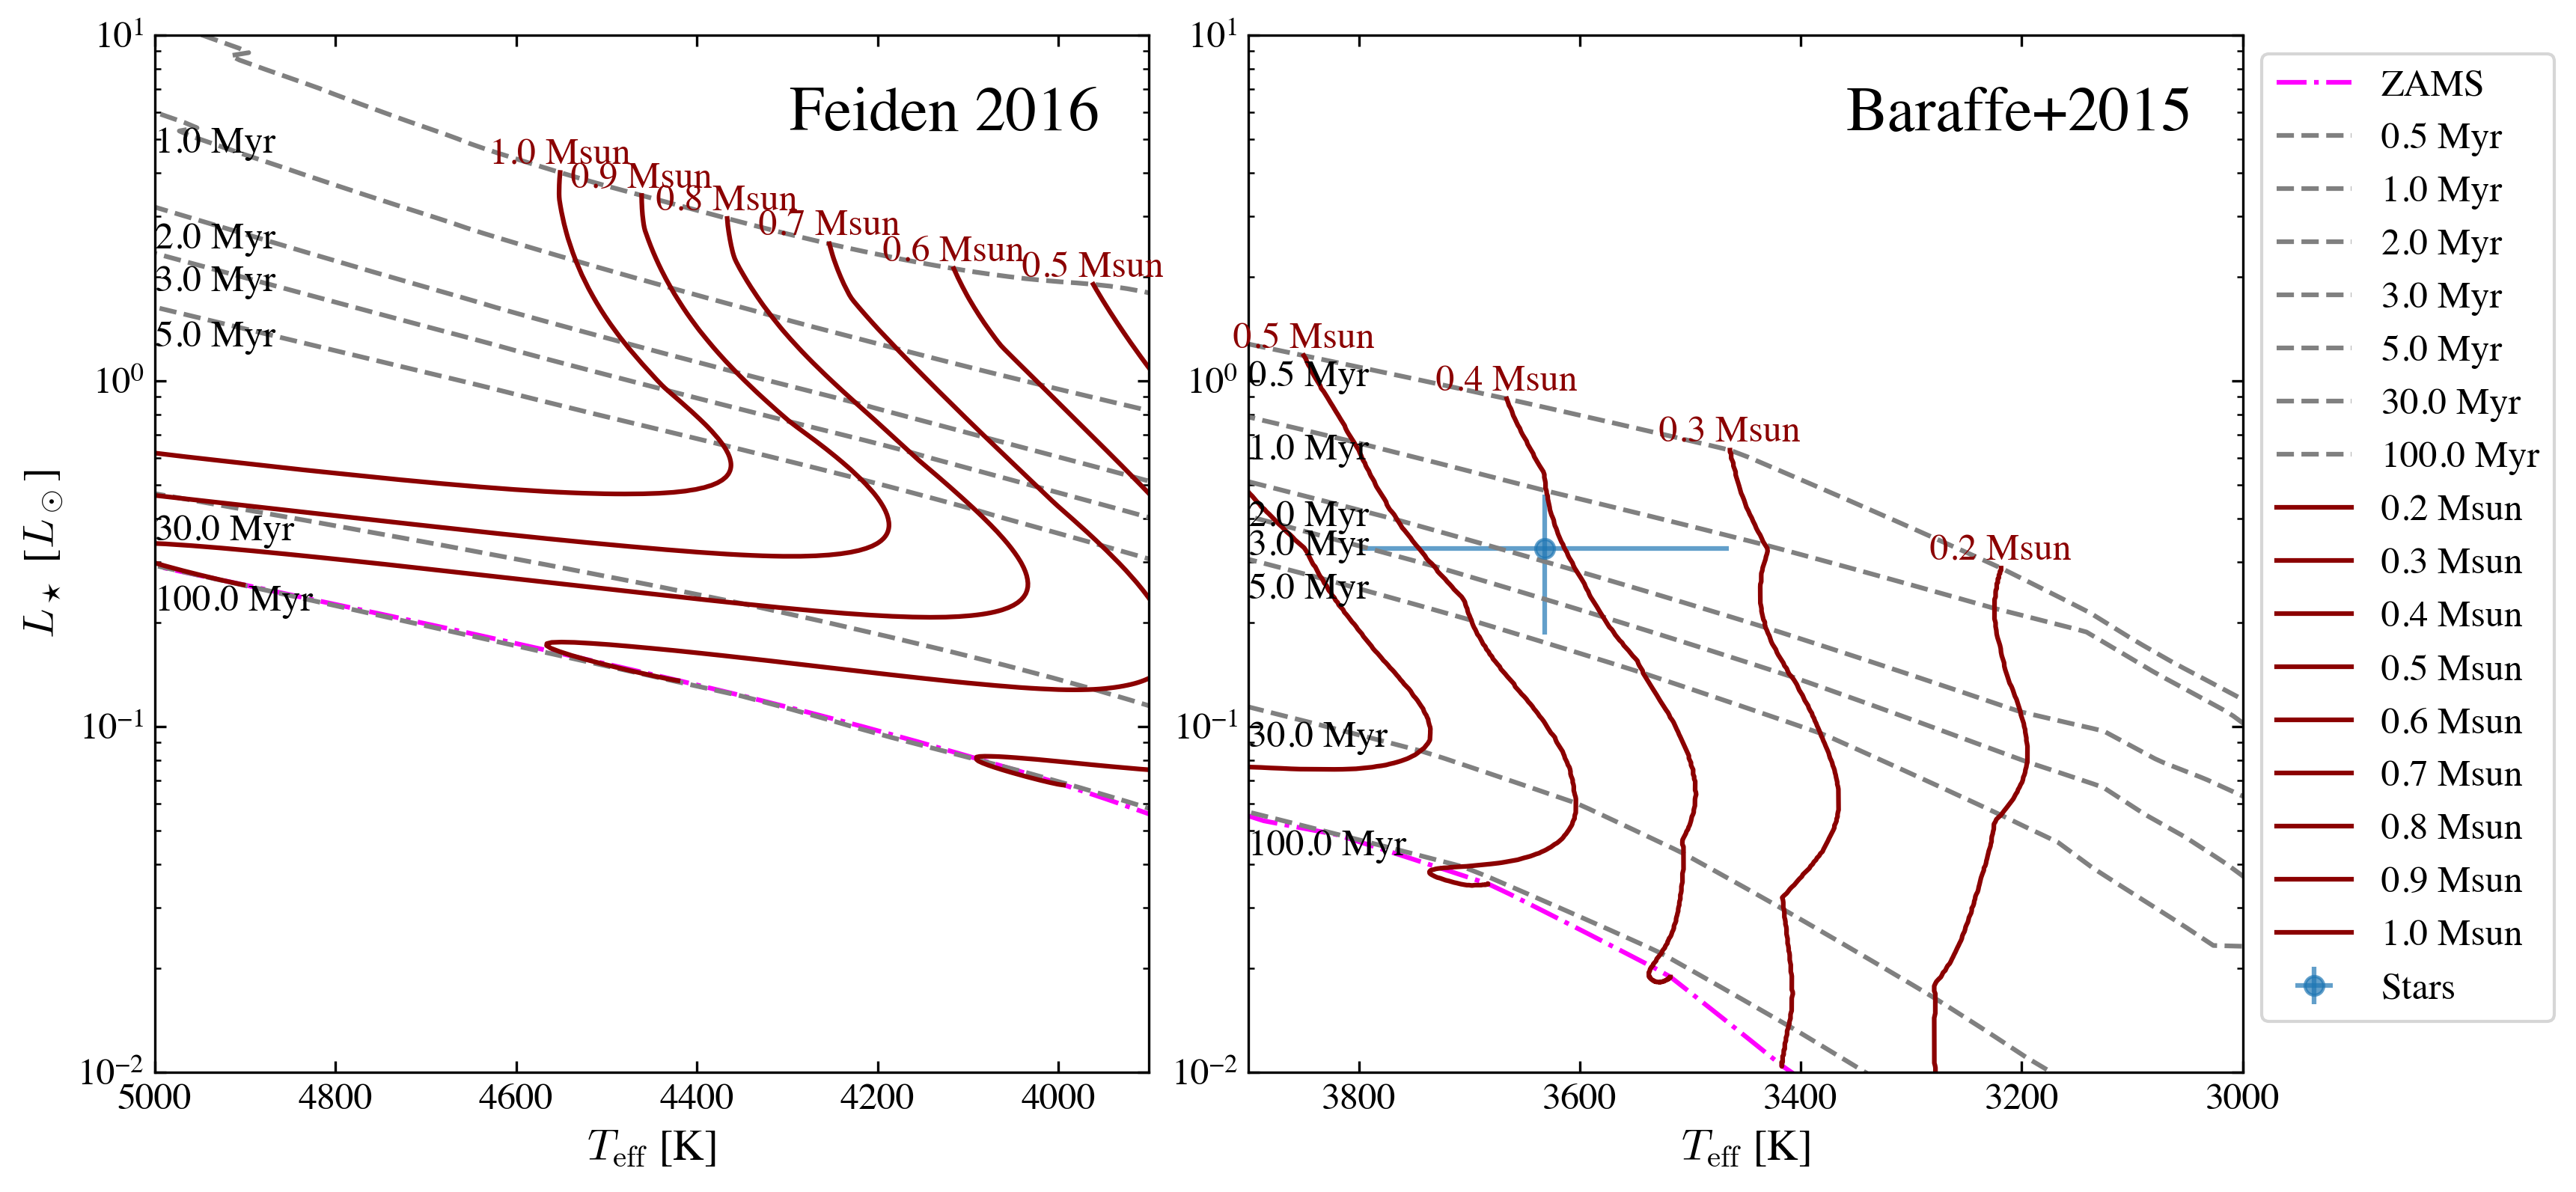

In [4]:
import matplotlib.pyplot as plt
# NOTE:
# if this is your first time using any of these tracks
# it would take longer to format the isochrones that you just downloaded
# and this block takes about 2 min on a Mac with M1 chip

ylim_set = [1e-2, 10]

fig, axes = plt.subplots(1,2,figsize=(12, 6),gridspec_kw={'wspace':0.1})

# set up the Isochrone class
isochrone = ysoisochrone.isochrone.Isochrone()
isochrone.set_tracks('Feiden2016')

ysoisochrone.plotting.plot_hr_diagram(isochrone, df_prop, ax_set=axes[0], xlim_set=[5000, 3900], ylim_set=ylim_set)

axes[0].get_legend().remove()
axes[0].annotate('Feiden 2016', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=20)

# set up the Isochrone class
isochrone = ysoisochrone.isochrone.Isochrone()
isochrone.set_tracks('Baraffe2015')

ysoisochrone.plotting.plot_hr_diagram(isochrone, df_prop, ax_set=axes[1], xlim_set=[3900, 3000], ylim_set=ylim_set)

axes[1].set_ylabel('')
axes[1].annotate('Baraffe+2015', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=20)

plt.show()

Here the blue points with errorbars are the stars with uncertainties; dark red solid lines are the stellar evolutionary tracks for different stellar masses; dashed grey lines are the isochorones; We also have an algrithm to automatically detect the zero-age-main-sequence (ZAMS) curve in the tracks, and that is shown as magenta dot-dashed line. 

**NOTE** 

- *On each track, the points that are older than the ZAMS will be ignored in the age/mass determination later.*
- *For the targets that are very close to ZAMS, their estimated ages cannot be trusted blindly, and they are in general less reliable*

## Estimate its age and mass from Bayesian inference approach

Our primary method is a Bayesian inference approach, and the `Python` code builds on the `IDL` version developed in [Pascucci et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...831..125P/abstract). 
The pre-main-sequence evolutionary models from both [Feiden (2016)](https://ui.adsabs.harvard.edu/abs/2016A%26A...593A..99F/abstract) and [Baraffe et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26A...577A..42B/abstract) are adopted for hot ($T_{\rm eff} > 3,900$) and cool stars ($T_{\rm eff} \leq 3,900$), respectively.

We provide a simple way to use this as

  0%|          | 0/1 [00:00<?, ?it/s]

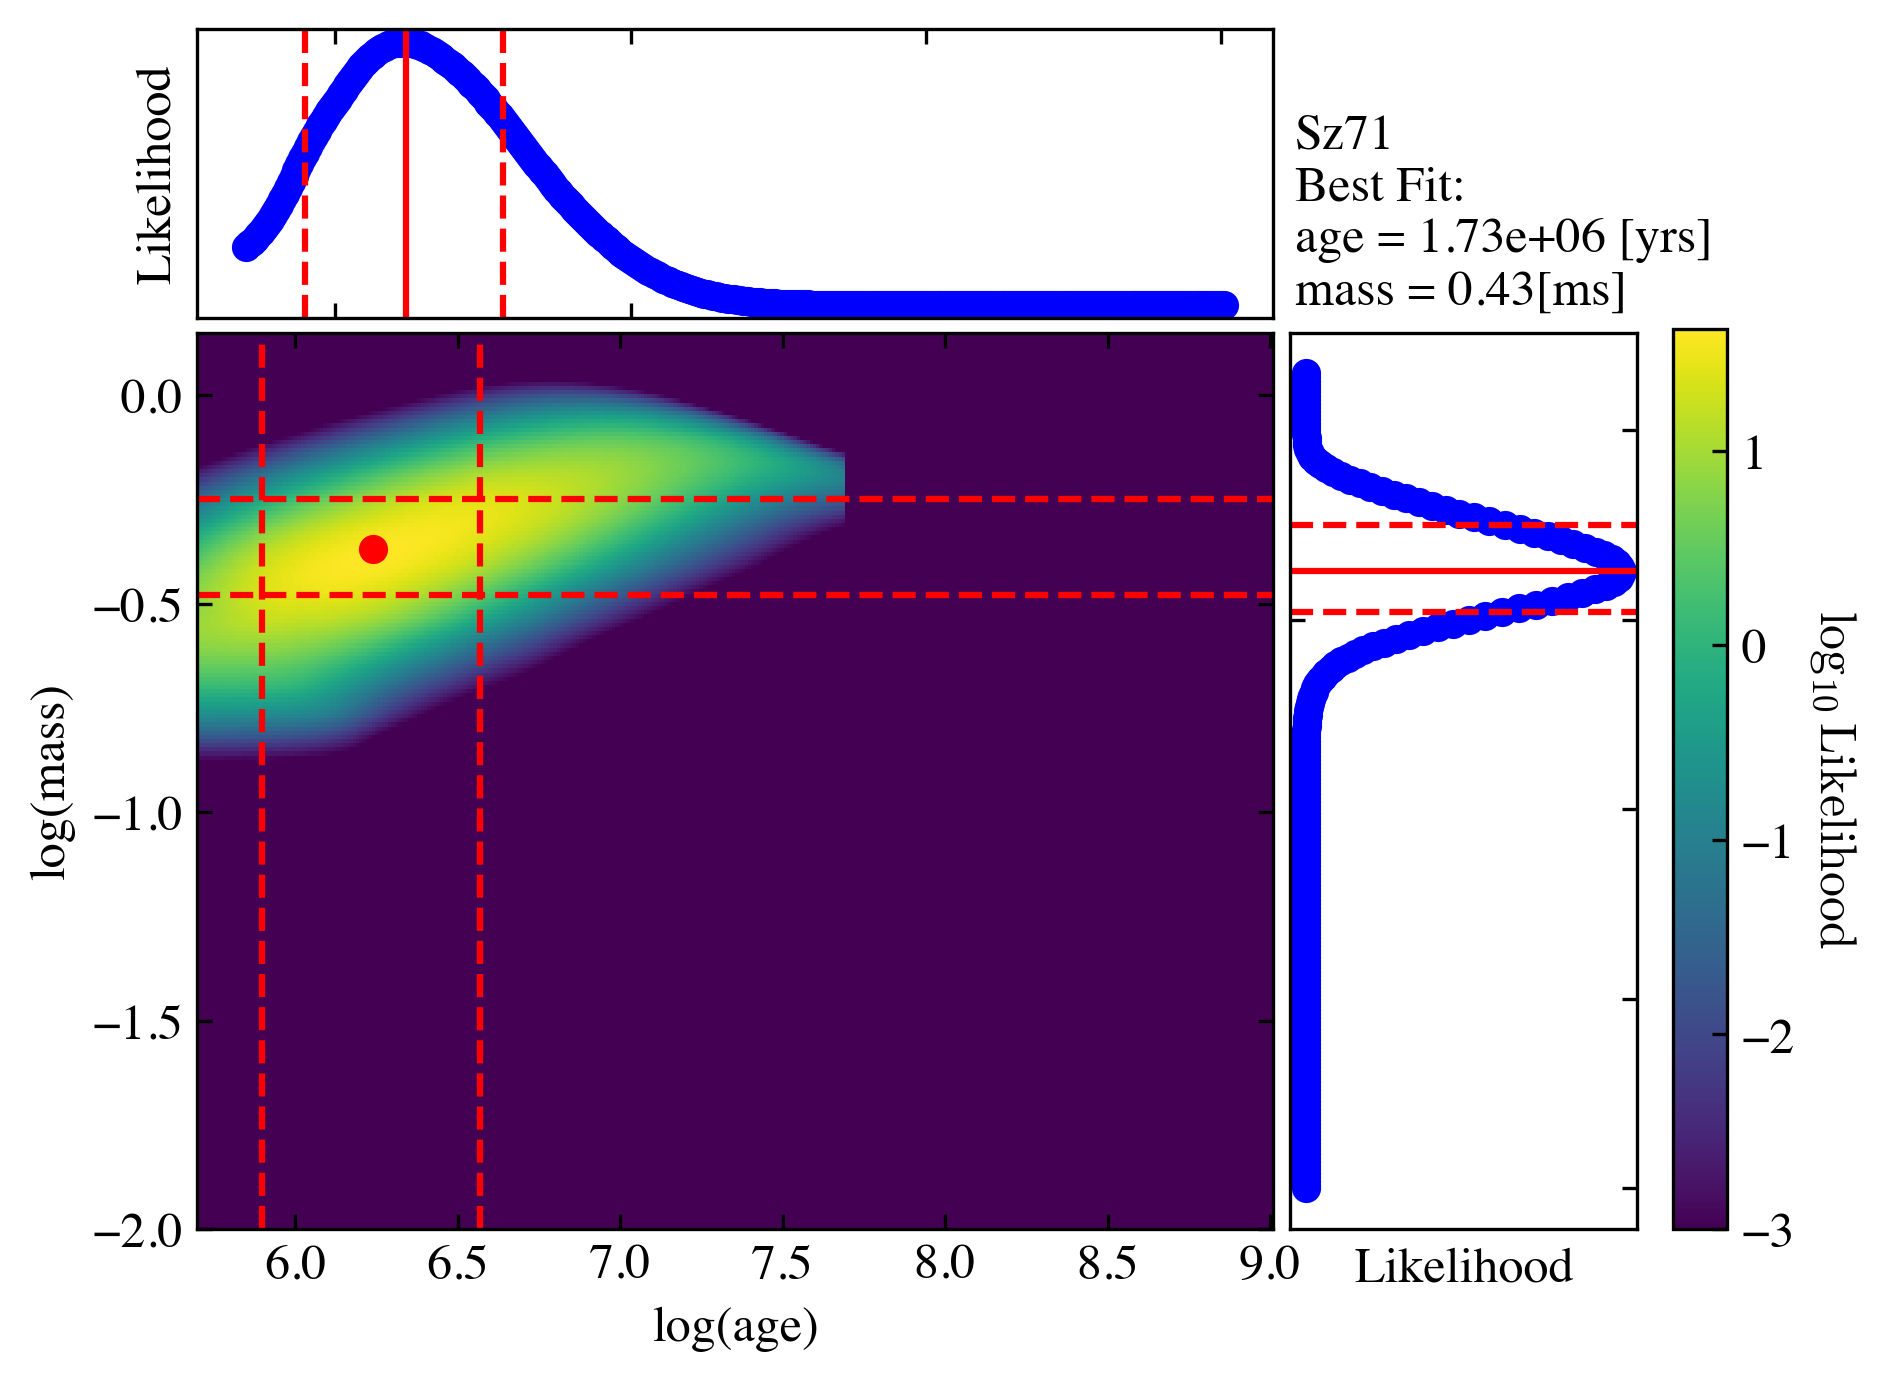

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


In [5]:
best_logmass_output, best_logage_output, lmass_all, lage_all =\
    ysoisochrone.bayesian.derive_stellar_mass_age(df_prop, model='Baraffe_n_Feiden', plot=True)

The `model` here is for calling different evolutionary tracks, by default we use `model='Baraffe_n_Feiden'`, which is the combination of Baraffe and Feiden tracks. Other choices include: `'Baraffe2015'`, `'Feiden2016'`, `'PARSEC_v2p0'` (same as `'PARSEC'`), `'PARSEC_v1p2'` or `'custome'`. If you want to use your own customized isochrone, you need to set the `model = 'custome'`, and also provide the absolute directory for the isochrone matrix file `isochrone_mat_file`. See [documentation](https://ysoisochrone.readthedocs.io/en/latest/index.html) for details. Here we also turn on the `plot = True` to show the intermediate diagnoostic plot.

The outputs are:

- (a) `best_logmass_output` (log10 of mass in the unit of solar masses), `best_logage_output` (log10 of age in the unit of yrs) are the arrays that includes the best derived values and their lower and upper boundaries from the 68% confidence intervals. 
- (b) `lmass_all` and `lage_all` are the distributions of the likelihood functions for each source; they could be used to estimate the medians based on the likelihood distributions.

An example of saving these outputs are

In [7]:
df_output_mass = pd.DataFrame(np.array(best_logmass_output), columns=['logmass[Msun]', 'lw_logmass[Msun]', 'up_logmass[Msun]'])
df_output_age = pd.DataFrame(np.array(best_logage_output), columns=['logage[yrs]', 'lw_logage[yrs]', 'up_logage[yrs]']) 
df_output = pd.concat([df_prop, df_output_mass, df_output_age], axis=1)

df_output.loc[:, 'mass[Msun]'] = 10**df_output.loc[:, 'logmass[Msun]']
df_output.loc[:, 'lw_mass[Msun]'] = 10**df_output.loc[:, 'lw_logmass[Msun]']
df_output.loc[:, 'up_mass[Msun]'] = 10**df_output.loc[:, 'up_logmass[Msun]']

df_output.loc[:, 'age[Myrs]'] = 10**df_output.loc[:, 'logage[yrs]']/1e6
df_output.loc[:, 'lw_age[Myrs]'] = 10**df_output.loc[:, 'lw_logage[yrs]']/1e6
df_output.loc[:, 'up_age[Myrs]'] = 10**df_output.loc[:, 'up_logage[yrs]']/1e6

for idx in df_output.index:
    print('For target %s'%(df_output.loc[idx, 'Source']))
    print('The estimated mass is: %.2f + %.2f - %.2f [Msun]'%(df_output.loc[idx, 'mass[Msun]'],\
            df_output.loc[idx, 'up_mass[Msun]']-df_output.loc[idx, 'mass[Msun]'],\
            df_output.loc[idx, 'mass[Msun]']-df_output.loc[idx, 'lw_mass[Msun]']))
    print('The estimated age is: %.2f + %.2f - %.2f [Myrs]'%(df_output.loc[idx, 'age[Myrs]'],\
            df_output.loc[idx, 'up_age[Myrs]']-df_output.loc[idx, 'age[Myrs]'],\
            df_output.loc[idx, 'age[Myrs]']-df_output.loc[idx, 'lw_age[Myrs]']))

For target Sz71
The estimated mass is: 0.43 + 0.14 - 0.10 [Msun]
The estimated age is: 1.73 + 1.97 - 0.94 [Myrs]


The distribution of the two likelihood functions for mass and age (`lmass` and `lage`) for this target has already been presented in the plot above. But if you want to take a look again, you can read them out follow this plotting script

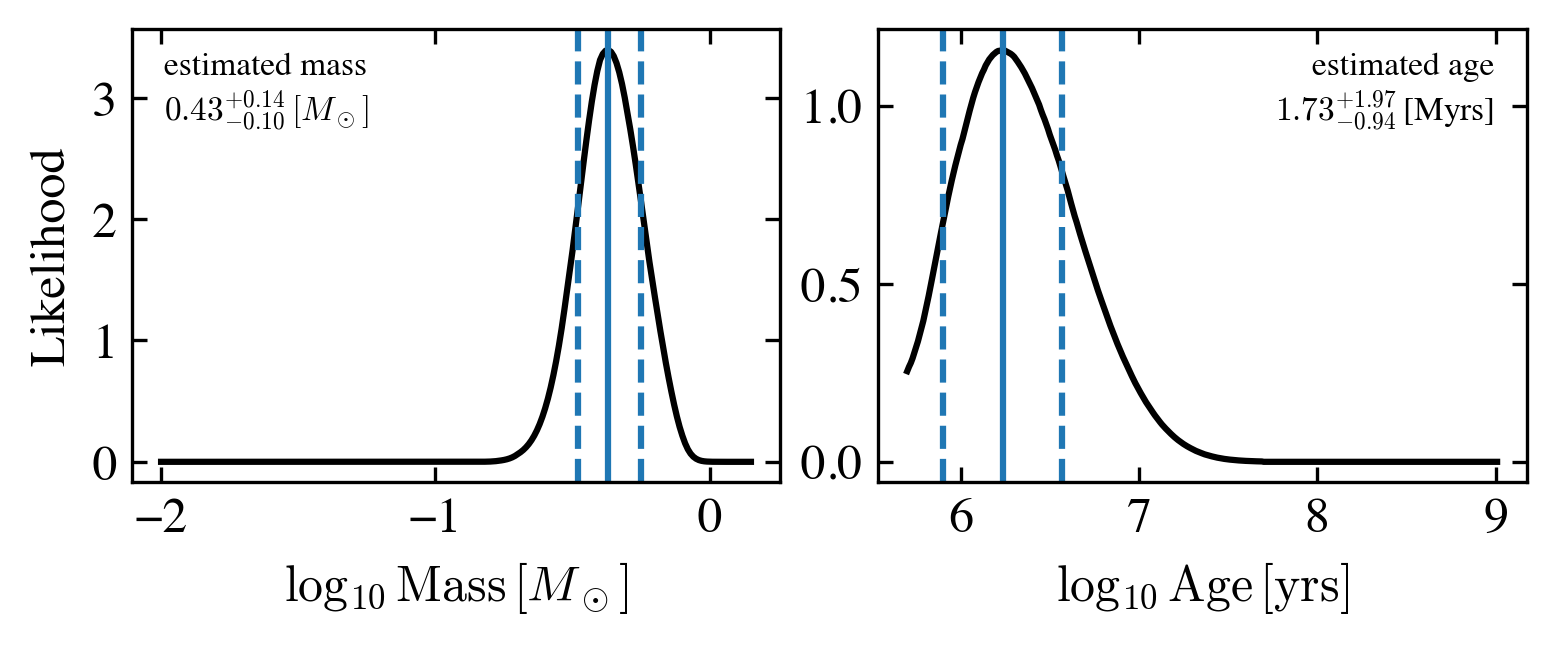

In [8]:
idx = 0
lmass_t = lmass_all['target_%i'%(idx)]
lage_t = lage_all['target_%i'%(idx)]

fig, axes = plt.subplots(1,2,figsize=(6, 2),gridspec_kw={'wspace':0.15})

axes[0].plot(lmass_t[0], lmass_t[1], color='k')

axes[0].axvline(df_output.loc[idx, 'logmass[Msun]'])
axes[0].axvline(df_output.loc[idx, 'up_logmass[Msun]'], linestyle='--')
axes[0].axvline(df_output.loc[idx, 'lw_logmass[Msun]'], linestyle='--')

text_mass = 'estimated mass\n' + '${%.2f}^{+%.2f}_{-%.2f}\,[M_\odot]$'%(df_output.loc[idx, 'mass[Msun]'],\
            df_output.loc[idx, 'up_mass[Msun]']-df_output.loc[idx, 'mass[Msun]'],\
            df_output.loc[idx, 'mass[Msun]']-df_output.loc[idx, 'lw_mass[Msun]'])
axes[0].annotate(text_mass, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=8)

axes[0].set_xlabel(r'$\log_{10}\,{\rm Mass}\,[M_\odot]$')
axes[0].set_ylabel('Likelihood')

axes[1].plot(lage_t[0], lage_t[1], color='k')

axes[1].axvline(df_output.loc[idx, 'logage[yrs]'])
axes[1].axvline(df_output.loc[idx, 'up_logage[yrs]'], linestyle='--')
axes[1].axvline(df_output.loc[idx, 'lw_logage[yrs]'], linestyle='--')

text_age = 'estimated age\n' + '${%.2f}^{+%.2f}_{-%.2f}\,$[Myrs]'%(df_output.loc[idx, 'age[Myrs]'],\
            df_output.loc[idx, 'up_age[Myrs]']-df_output.loc[idx, 'age[Myrs]'],\
            df_output.loc[idx, 'age[Myrs]']-df_output.loc[idx, 'lw_age[Myrs]'])
axes[1].annotate(text_age, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=8)

axes[1].set_xlabel(r'$\log_{10}\,{\rm Age}\,[{\rm yrs}]$')
axes[1].set_ylabel('')

plt.show()

of course you can save these output

In [9]:
# Then you can save this output file
df_output.to_csv('example_target_one_o.csv', index=False)

## Your first large dataset

### Read in a csv table

When dealing with larger dataset, the easiest way is to create a `.csv` file using EXCEL or similar software, and this file includes these columns, and then you can utilize `pandas` to read in this file. Later you use this as an input.

Here we prepared an example file called `'example_targets.csv'` in this tutorial. This is the Cham I sample that discussed in [Pascucci et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...831..125P/abstract).

In [2]:
df_prop = pd.read_csv('example_targets.csv', comment='#')

df_prop

,Source,Teff[K],Luminosity[Lsun],Ref
0,J10533978-7712338,3560.0,0.016,M16b
1,J10555973-7724399,4060.0,0.180,M16a
2,J10561638-7630530,2935.0,0.080,M16b
3,J10563044-7711393,4060.0,0.430,M16a
4,J10574219-7659356,3415.0,0.530,M16b
...,...,...,...,...
88,J11173700-7704381,3780.0,0.420,M14
89,J11175211-7629392,3198.0,0.087,L07
90,J11183572-7935548,3125.0,0.260,M16b
91,J11241186-7630425,3060.0,0.030,M16b


Reference here: L07 = [Luhman (2007)](https://ui.adsabs.harvard.edu/abs/2007ApJS..173..104L/abstract); M14 = [Manara et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..18M/abstract); M16a = [Manara et al. 2016a](https://ui.adsabs.harvard.edu/abs/2016A%26A...585A.136M/abstract); M16b = [Manara et al. 2016b](https://ui.adsabs.harvard.edu/abs/2016A%26A...591L...3M/abstract). They are also summarized in the head of the `'example_targets.csv'`.

**NOTE**

The uncertainties for $T_{\rm eff}$ and $L$ are required in this approach, if you have no idea on what would be the `'e_Teff[K]'` and/or `'e_Luminosity[Lsun]'` (or just want a quick test), you can turn on the option `no_uncertainties=True` in `ysoisochrone.bayesian.derive_stellar_mass_age`. In this way, the code will automatically assign the uncertainties to your sample following the choice made in [Pascucci et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...831..125P/abstract) with the pre-assumed uncertainties for $T_{\rm eff}$ and $L$: 

- $\sigma(\log_{10}{T_{\rm eff}}) = 0.02$ for $T_{\rm eff} > 3420.0\,{\rm K}$ and $\sigma(\log_{10}{T_{\rm eff}}) = 0.01$ for cooler targets.
- $\sigma(\log_{10}L = 0.1)$ for all targets

You can also assign these default uncertainties to your `DataFrame` (`df_prop`) by calling

In [3]:
err_Teff = ysoisochrone.utils.assign_unc_teff(df_prop['Teff[K]'].values)
err_Lumi = ysoisochrone.utils.assign_unc_lumi(df_prop['Luminosity[Lsun]'].values)
df_prop['e_Teff[K]'] = err_Teff
df_prop['e_Luminosity[Lsun]'] = err_Lumi

*we encourage the users to set up your own uncertainties* in the input `df_prop` for your targets even you do not have the meausred values. You can do this by changing the numbers in the input `.csv` file or utilize the feature for `pandas.DataFrame` 

```python
df_prop.loc[:, 'e_Teff[K]'] = # An array of the e_Teff you set up
df_prop.loc[:, 'e_Luminosity[Lsun]'] = # An array of the e_Luminosity you set up
```

**TIPS** 

`pandas.DataFrame` is a very versatile class. Please refer to [Data Frame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) for how to handle the `pandas.DataFrame`. It is a powerful tool that you can not only import data from `.csv` files but many other format such as `.xlsx`, `.json`, and `.html`. For theo output files, it can also be utilized to generate `latex` format files `.tex` so it can be easily import to your on going `latex` manuscript.

One useful script for astronomers could be reading the machine readable tables (MRT), such as the [table 1 in Pascucci et al. 2016](https://content.cld.iop.org/journals/0004-637X/831/2/125/revision1/apjaa3a39t1_mrt.txt) (*you need to download your own MRT tables*)

```python
import astropy.io.ascii
# read in the Pasccuci+2016 table 1
file_t = os.path.join(file_dir_t, 'yourtable_mrt.txt')
# Read the table with the correct data start line
table_t = ascii.read(file_t, delimiter='|')
# Convert to pandas DataFrame
df_yourtable = table_t.to_pandas()
```

### Have a look on HRD and define targets that are toobright and/or too faint

You can overplot them on the top of the isochrones in the Hertzsprung–Russell diagram (HR diagram) and check for the targets that are too bright/faint. 

**WARNING**
Normaly we need to assign ages to the targets that are too bright/faint otherwise the Bayesian method would not give a robust estimate. So we assign the age as follows and find their best-fit masses from the cloest track.

- for targets that are too bright, we assign the youngest age from the model grid. 
- for targets that are too faint (could because it has an edge-on disk), we assign the median age of the star-forming region.

In [12]:
# you need to specify the source names
toobright = ['J11065906-7718535','J11094260-7725578',
   		     'J11105597-7645325','J11183572-7935548']
toofaint = ['J10533978-7712338','J11063945-7736052','J11082570-7716396',
            'J11111083-7641574','J11160287-7624533']

# the median age for Cham I star-forming region
median_age = 6.48 # Myrs, the age took from Pasucci+2016 choice

In [13]:
# form the df_toobright and df_toofaint only for plot
idx_toobright = []
idx_toofaint  = []
for idx_t in df_prop.index:
    if df_prop.loc[idx_t, 'Source'] in toobright:
        idx_toobright.append(idx_t)
    if df_prop.loc[idx_t, 'Source'] in toofaint:
        idx_toofaint.append(idx_t)

df_toobright = df_prop.loc[idx_toobright]
df_toofaint = df_prop.loc[idx_toofaint]

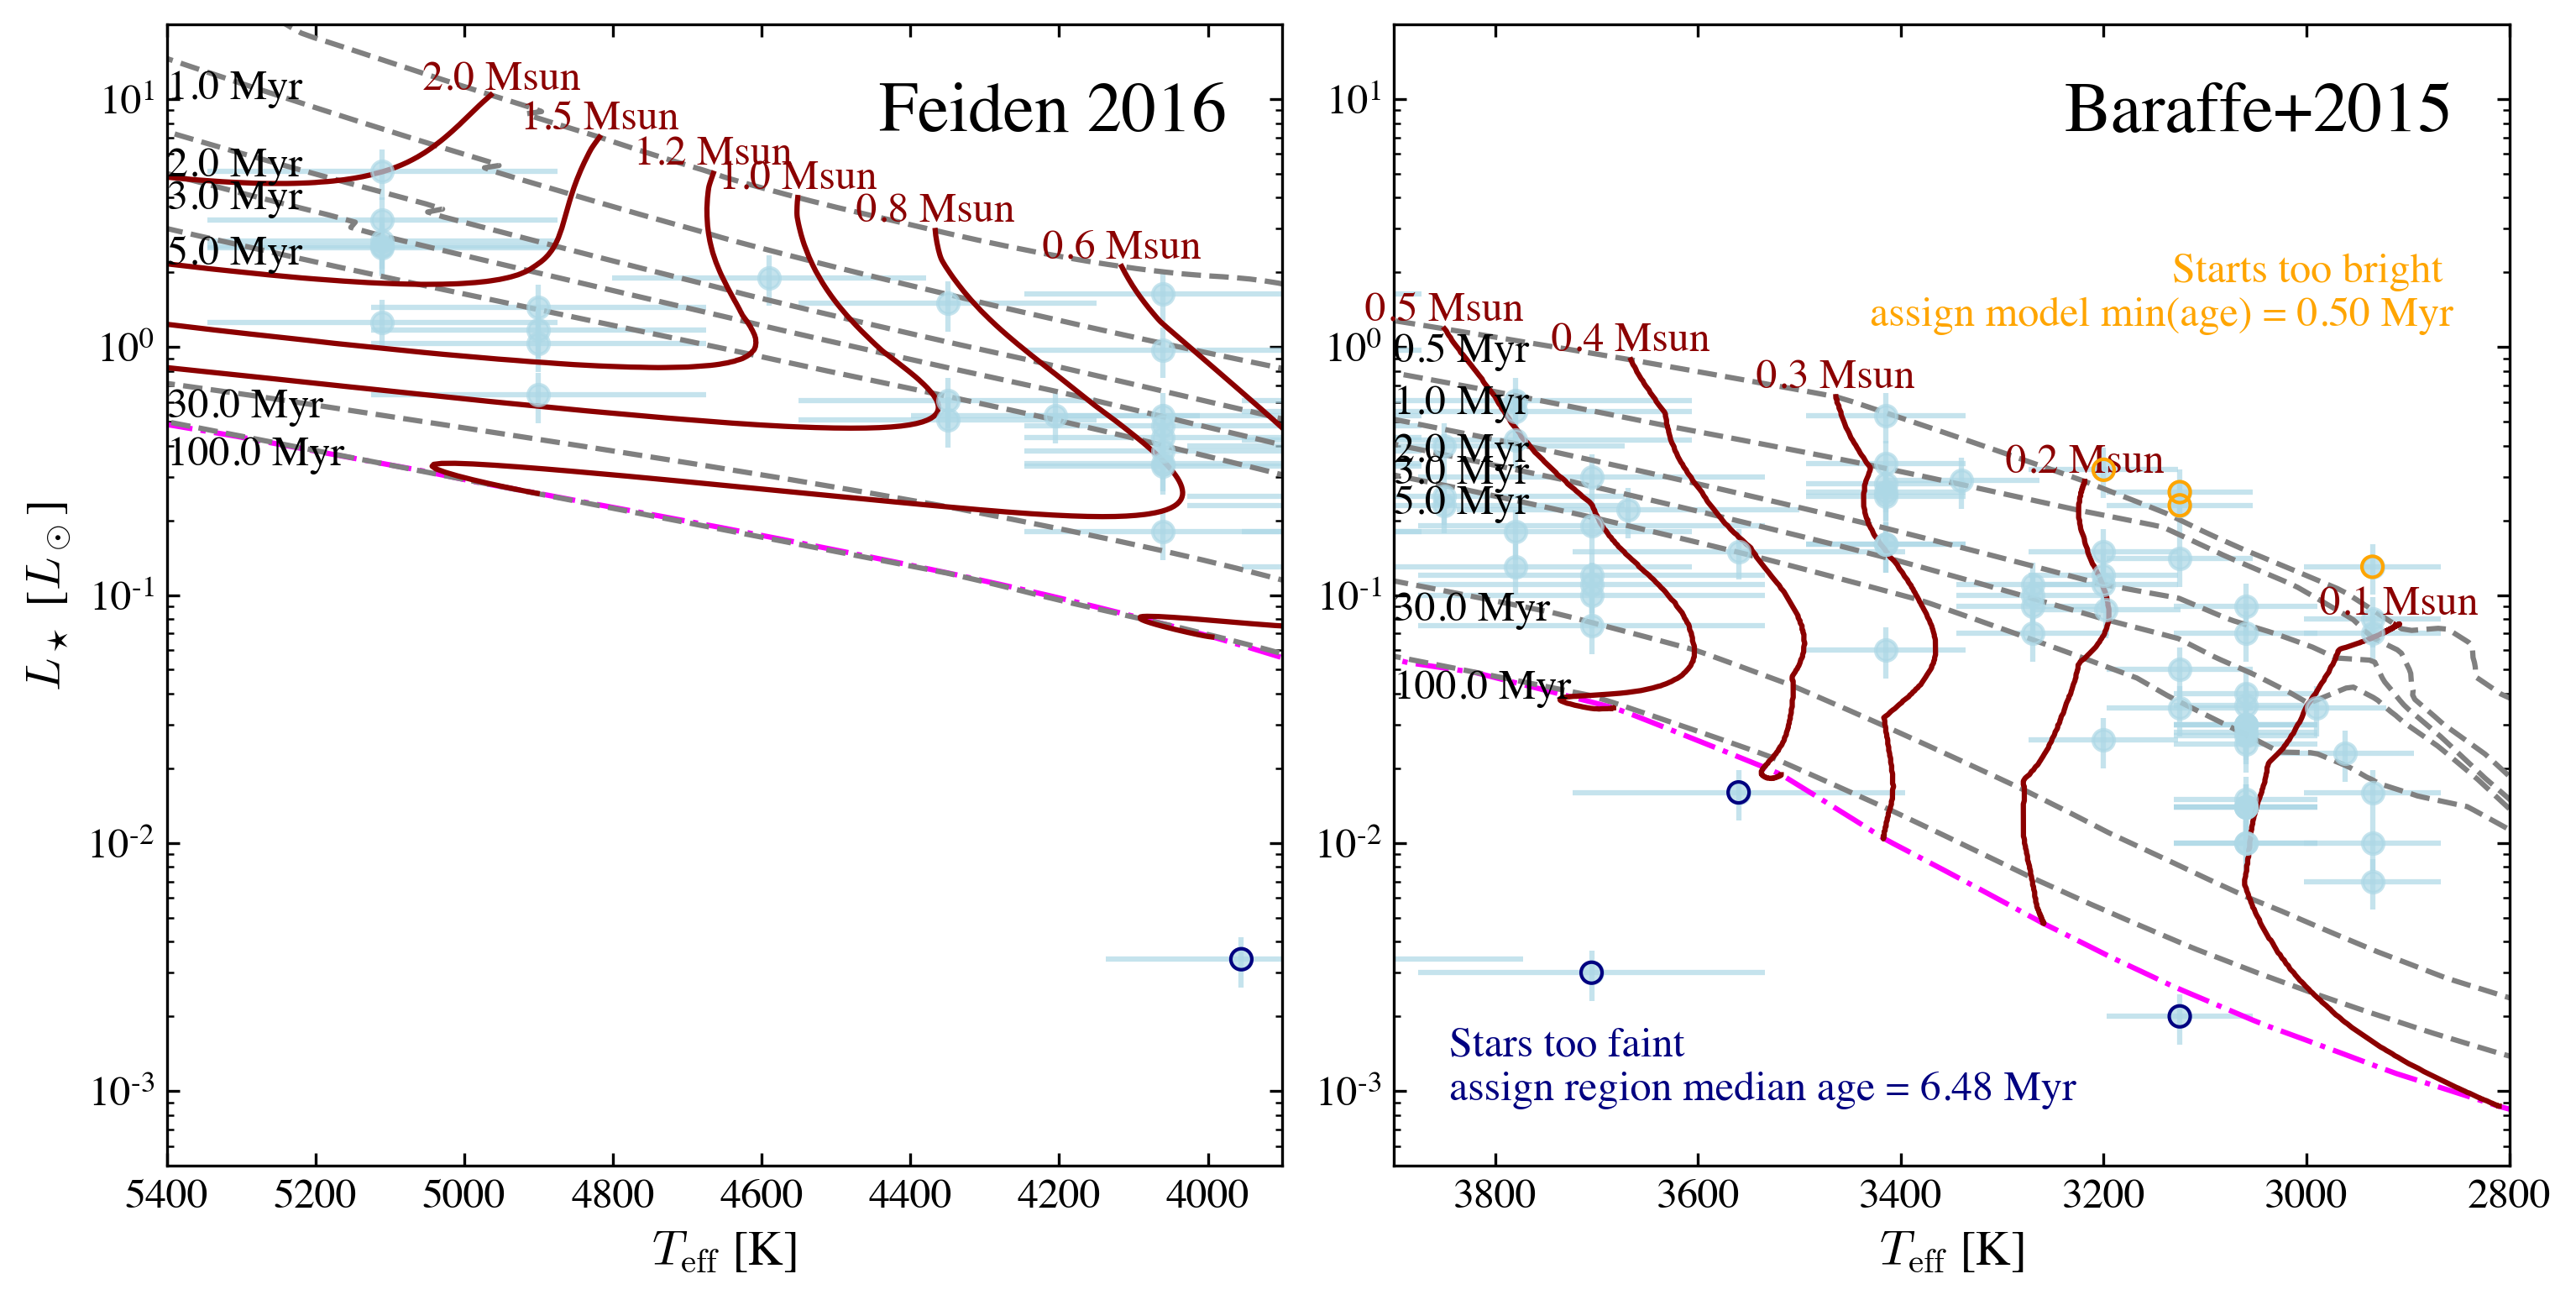

In [14]:
# Plot HDR

ylim_set = [5e-4, 20]

fig, axes = plt.subplots(1,2,figsize=(12, 6),gridspec_kw={'wspace':0.1})

# set up the Isochrone class
isochrone = ysoisochrone.isochrone.Isochrone()
isochrone.set_tracks('Feiden2016')

# sometimes the automatic algrithm does not give good-looking texts
# you can change them like this:
# define user customized masses texts
masses_to_plot_t = [0.6,   0.8,   1.0,   1.2,   1.5,   2.0]
mass_positions_t = ['auto','auto','auto','auto','auto',(4950, 10)] # the tuple is the data location for this text
# you can also change the rotaion of the texts
# mass_rotation_t  = [0,      0,     0,     0,      0,    -19]

ysoisochrone.plotting.plot_hr_diagram(isochrone, df_prop, ax_set=axes[0], xlim_set=[5400, 3900], ylim_set=ylim_set,
                                      color_stars='lightblue',
                                      masses_to_plot=masses_to_plot_t, 
                                      mass_positions=mass_positions_t)
# some additional useful parameters that can be changed for plot_hr_diagram
# mass_rotation=mass_rotation_t,
# ages_to_plot=[0.5e6, 1.0e6, 5.0e6, 10.0e6, 100.0e6], # in the unit of yr
# age_positions=['auto','auto','auto','auto','auto']
# age_rotation=[0,      0,     0,     0,      0]

axes[0].get_legend().remove()
axes[0].annotate('Feiden 2016', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=20)

# set up the Isochrone class
isochrone = ysoisochrone.isochrone.Isochrone()
isochrone.set_tracks('Baraffe2015')

masses_to_plot_t = [0.1, 0.2, 0.3, 0.4, 0.5]
ysoisochrone.plotting.plot_hr_diagram(isochrone, df_prop, ax_set=axes[1], xlim_set=[3900, 2800], ylim_set=ylim_set,
                                      color_stars='lightblue',
                                      masses_to_plot=masses_to_plot_t)

axes[1].set_ylabel('')
axes[1].get_legend().remove()
axes[1].annotate('Baraffe+2015', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=20)

# plot the too bright and too faint ones
for ax_t in axes:
    ax_t.scatter(df_toobright['Teff[K]'].values, df_toobright['Luminosity[Lsun]'].values, edgecolor='orange', color='None', zorder=10)
    ax_t.scatter(df_toofaint['Teff[K]'].values, df_toofaint['Luminosity[Lsun]'].values, edgecolor='navy', color='None', zorder=10)

axes[1].annotate('Stars too faint \nassign region median age = %.2f Myr'%(median_age), 
                 (0.05, 0.05), xycoords='axes fraction', ha='left', va='bottom',
                 color='navy')
axes[1].annotate('Starts too bright \nassign model min(age) = %.2f Myr'%(10**np.nanmin(isochrone.log_age)/1e6), 
                 (0.95, 0.80), xycoords='axes fraction', ha='right', va='top',
                 color='orange')

plt.show()

### Estimate Mass and Ages

Then, to estimate their masses and ages using the Bayesian inference approach

In [15]:
best_logmass_output, best_logage_output, lmass_all, lage_all =\
    ysoisochrone.bayesian.derive_stellar_mass_age(df_prop, model='Baraffe_n_Feiden', toobright=toobright, toofaint=toofaint, median_age=median_age) 
# other useful options.
# isochrone_data_dir=None, no_uncertainties=True, plot=False, save_fig=False, save_lfunc=False, fig_save_dir='figures', csv_save_dir='lfunc_data', verbose=False

100%|██████████| 93/93 [00:44<00:00,  2.10it/s]


An example of saving these `output` numbers are

In [16]:
df_output_mass = pd.DataFrame(np.array(best_logmass_output), columns=['logmass[Msun]', 'lw_logmass[Msun]', 'up_logmass[Msun]'])
df_output_age = pd.DataFrame(np.array(best_logage_output), columns=['logage[yrs]', 'lw_logage[yrs]', 'up_logage[yrs]']) 
df_output = pd.concat([df_prop, df_output_mass, df_output_age], axis=1)

df_output.loc[:, 'mass[Msun]'] = 10**df_output.loc[:, 'logmass[Msun]']
df_output.loc[:, 'lw_mass[Msun]'] = 10**df_output.loc[:, 'lw_logmass[Msun]']
df_output.loc[:, 'up_mass[Msun]'] = 10**df_output.loc[:, 'up_logmass[Msun]']

df_output.loc[:, 'age[Myrs]'] = 10**df_output.loc[:, 'logage[yrs]']/1e6
df_output.loc[:, 'lw_age[Myrs]'] = 10**df_output.loc[:, 'lw_logage[yrs]']/1e6
df_output.loc[:, 'up_age[Myrs]'] = 10**df_output.loc[:, 'up_logage[yrs]']/1e6

df_output

,Source,Teff[K],Luminosity[Lsun],Ref,e_Teff[K],e_Luminosity[Lsun],logmass[Msun],lw_logmass[Msun],up_logmass[Msun],logage[yrs],lw_logage[yrs],up_logage[yrs],mass[Msun],lw_mass[Msun],up_mass[Msun],age[Myrs],lw_age[Myrs],up_age[Myrs]
0,J10533978-7712338,3560.0,0.016,M16b,163.944059,0.003684,-0.430000,0.000000,0.000000,6.48000,0.00000,0.00000,0.371535,1.000000,1.000000,3.019952,0.000001,0.000001
1,J10555973-7724399,4060.0,0.180,M16a,186.969910,0.041447,-0.125757,-0.165757,-0.045757,7.17897,6.91897,7.44897,0.748587,0.682720,0.900000,15.099759,8.297935,28.117066
2,J10561638-7630530,2935.0,0.080,M16b,67.580872,0.018421,-0.960000,-1.010000,-0.880000,5.70897,5.69897,5.90897,0.109648,0.097724,0.131826,0.511646,0.500000,0.810905
3,J10563044-7711393,4060.0,0.430,M16a,186.969910,0.099011,-0.065757,-0.145757,0.024243,6.60897,6.34897,6.87897,0.859493,0.714895,1.057408,4.064153,2.233418,7.567806
4,J10574219-7659356,3415.0,0.530,M16b,78.633281,0.122037,-0.530000,-0.570000,-0.480000,5.76897,5.69897,5.85897,0.295121,0.269153,0.331131,0.587449,0.500000,0.722720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,J11173700-7704381,3780.0,0.420,M14,174.075433,0.096709,-0.290000,-0.400000,-0.180000,6.25897,5.98897,6.51897,0.512861,0.398107,0.660693,1.815390,0.974922,3.303467
89,J11175211-7629392,3198.0,0.087,L07,73.636671,0.020032,-0.700000,-0.780000,-0.630000,6.42897,6.25897,6.59897,0.199526,0.165959,0.234423,2.685159,1.815390,3.971641
90,J11183572-7935548,3125.0,0.260,M16b,71.955784,0.059867,-0.780000,0.000000,0.000000,5.69897,0.00000,0.00000,0.165959,1.000000,1.000000,0.500000,0.000001,0.000001
91,J11241186-7630425,3060.0,0.030,M16b,70.459104,0.006908,-0.920000,-1.010000,-0.820000,6.64897,6.47897,6.80897,0.120226,0.097724,0.151356,4.456255,3.012798,6.441248


In [17]:
# Then you can save this output file
df_output.to_csv('example_targets_o.csv', index=False)

## Quick demo on other methods

Now you already know how to work with your dataset, here we provide a quick demo on how to utilize other methods provided in this package

### Closest grid point on isochrone

Of course we provide this option for you to simply estimate the stellar masses and ages from the grid point that has the closest $T_{\rm eff}$ and $L_{\rm bol}$ to the target without using any Bayesian inference. This was the approach adopted in many literature works.

In [18]:
df_prop_t = df_prop.loc[:0]

best_logmass_output, best_logage_output = ysoisochrone.bayesian.derive_stellar_mass_age_closest_track(df_prop_t, model='Baraffe_n_Feiden', verbose=True)

100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

Working on: J10533978-7712338
Closest match for J10533978-7712338: Age = 1.95e+08 yrs, Mass = 3.72e-01 Msun


**NOTE** In this method, we do not estimate the uncertainties. The output best-fit logmass and logage are the closest track and no uncertainties are provided.

### Assuming age to derive stellar masses

In some cases, when a good measurement of stellar luminosity is unavailable,  we also provide an option to set up the assumed age (`assumed_age=6.48e6` in the example, it is in the unit of yr) to derive the stellar mass from the Bayesian inference. 

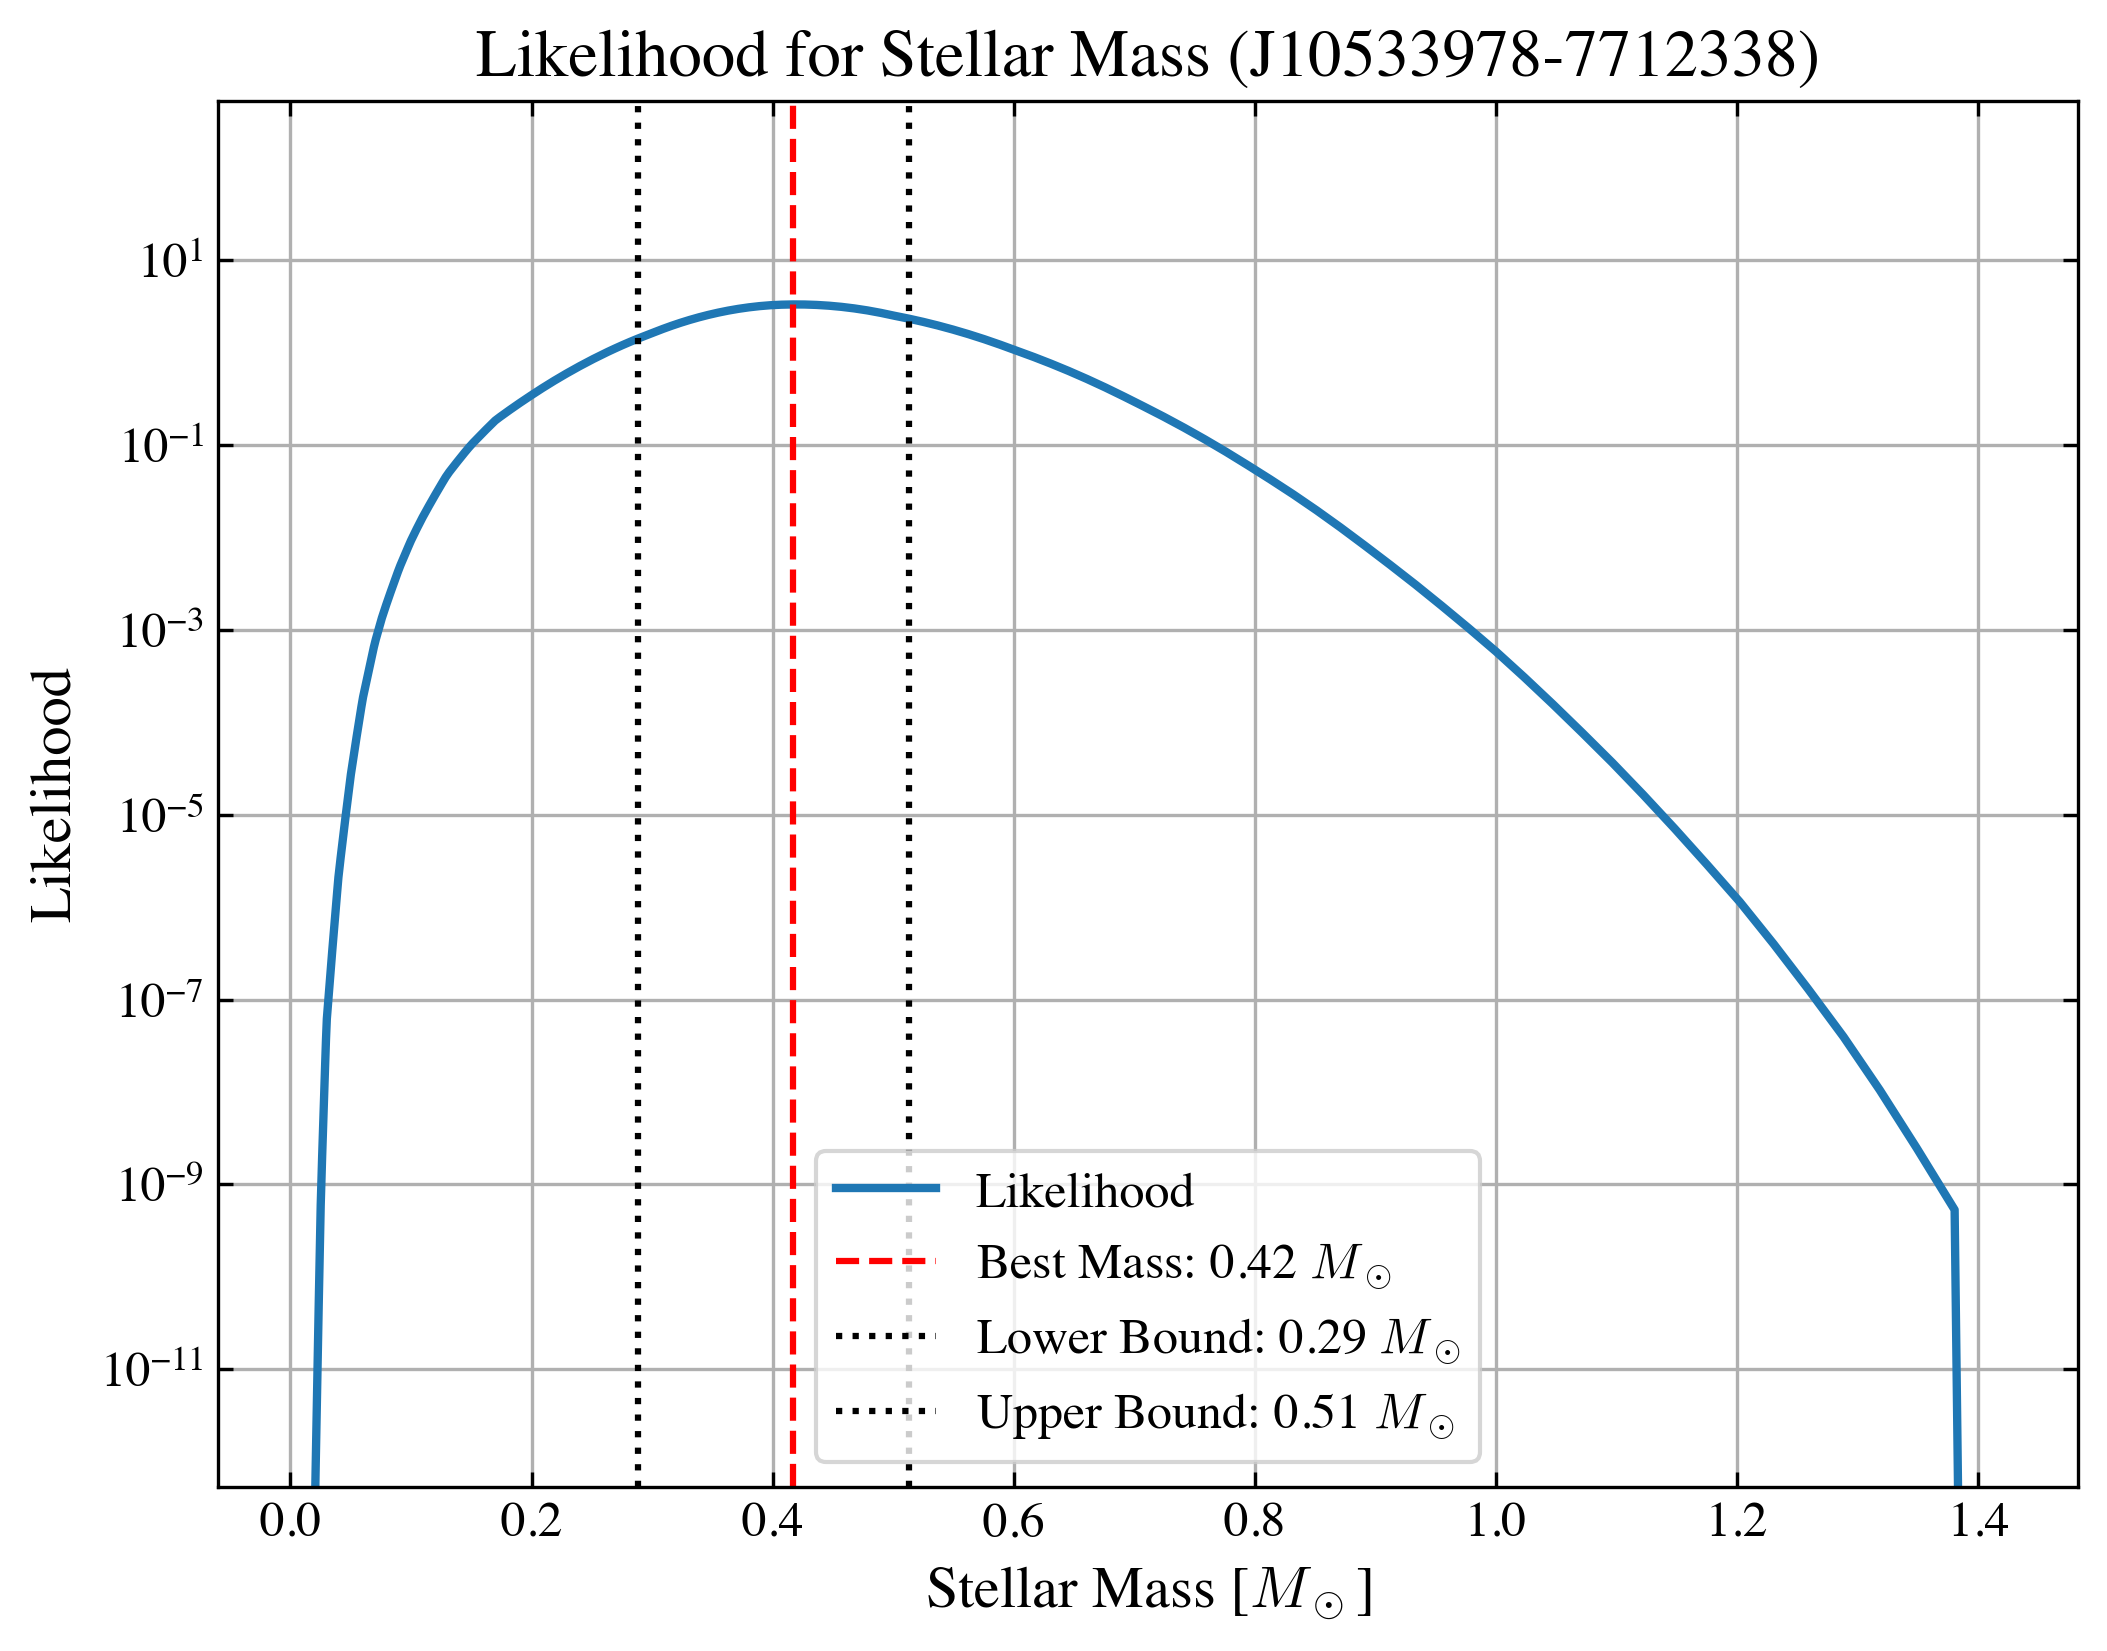

The estimated mass is: 0.42 + 0.10 - 0.13 [Msun]


In [4]:
# only take one target as an example
idx = 0
df_prop_t = df_prop.loc[[idx]]

best_logmass_output_t = ysoisochrone.bayesian.derive_stellar_mass_assuming_age(df_prop_t, assumed_age=6.48e6, model='Baraffe_n_Feiden', plot=True)

df_output_mass_t = pd.DataFrame(np.array(best_logmass_output_t), columns=['logmass[Msun]', 'lw_logmass[Msun]', 'up_logmass[Msun]'])
df_output_t = pd.concat([df_prop_t, df_output_mass_t], axis=1)
df_output_t.loc[:, 'mass[Msun]'] = 10**df_output_t.loc[:, 'logmass[Msun]']
df_output_t.loc[:, 'lw_mass[Msun]'] = 10**df_output_t.loc[:, 'lw_logmass[Msun]']
df_output_t.loc[:, 'up_mass[Msun]'] = 10**df_output_t.loc[:, 'up_logmass[Msun]']

print('The estimated mass is: %.2f + %.2f - %.2f [Msun]'%(df_output_t.loc[idx, 'mass[Msun]'],\
                      df_output_t.loc[idx, 'up_mass[Msun]']-df_output_t.loc[idx, 'mass[Msun]'],\
                      df_output_t.loc[idx, 'mass[Msun]']-df_output_t.loc[idx, 'lw_mass[Msun]']))

Or you can simply get the one with closest track, and this is the method adopted in [Pascucci et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...831..125P/abstract) for the targets that do not have good luminosity measurement. 

**NOTE** This function is only provided to reproduce the results from literature, and as what was did there the uncertainties were not provided, and only the best fit mass is the output. We recommand using the Bayesian approaches (with assumed age) where the uncertainties can be obtained.

In [21]:
# only take one target as an example
idx = 0
df_prop_t = df_prop.loc[[idx]]

best_logmass_output_t = ysoisochrone.bayesian.derive_stellar_mass_assuming_age_closest_trk(df_prop_t, assumed_age=6.48e6, model='Baraffe_n_Feiden')

print('estimated mass: %.2f [Msun]'%(10**best_logmass_output_t[0]))

estimated mass: 0.42 [Msun]
